Accredian Internship Task


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Install required libraries
!pip install -q scikit-learn imbalanced-learn xgboost


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/Fraud.csv')

In [ ]:
print(df.shape)
print(df.info())
print(df.head())

(6362620, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        4155

In [ ]:
# Check missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [ ]:
df['isMerchant'] = df['nameDest'].str.startswith('M')

In [ ]:
# Feature engineering for impossible balance (error flag)
df['errorBalanceFlag'] = (
    ((df['oldbalanceOrg'] == 0) & (df['newbalanceOrig'] == 0) & (df['amount'] != 0)) |
    ((df['oldbalanceDest'] == 0) & (df['newbalanceDest'] == 0) & (df['amount'] != 0) & (~df['isMerchant']))
).astype(int)

In [ ]:
# Create difference features to reduce multicollinearity
df['balanceDiffOrig'] = df['newbalanceOrig'] - df['oldbalanceOrg']
df['balanceDiffDest'] = df['newbalanceDest'] - df['oldbalanceDest']

In [ ]:
# Log-transform amount to handle skewness
df['log_amount'] = np.log1p(df['amount'])

In [ ]:
# One-hot encode 'type' variable
df = pd.get_dummies(df, columns=['type'], drop_first=False)

isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


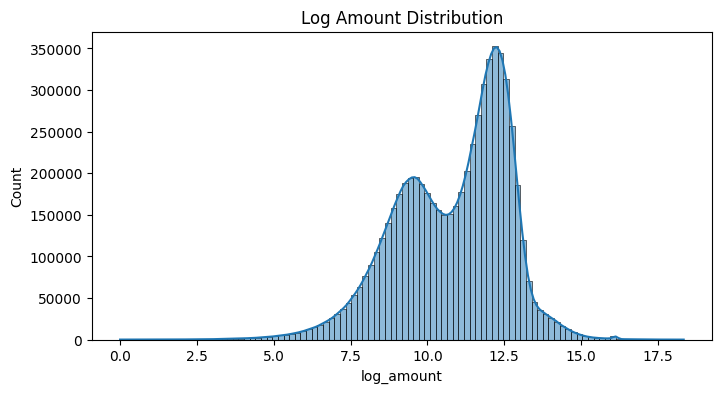

In [ ]:
# Explore fraud class imbalance
print(df['isFraud'].value_counts(normalize=True))

# Visualize 'amount' distribution (log scale)
plt.figure(figsize=(8,4))
sns.histplot(df['log_amount'], bins=100, kde=True)
plt.title('Log Amount Distribution')
plt.show()

In [ ]:
# Multicollinearity check: Calculate VIF on selected numerical features
features_for_vif = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'amount']
X_vif = df[features_for_vif].fillna(0)
vif_data = pd.DataFrame()
vif_data['feature'] = features_for_vif
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print(vif_data)

          feature         VIF
0   oldbalanceOrg  464.011728
1  newbalanceOrig  465.356124
2  oldbalanceDest   70.452251
3  newbalanceDest   82.167173
4          amount    3.861988


In [ ]:
# Define features and target for modeling
feature_cols = [
    'log_amount',
    'balanceDiffOrig',
    'balanceDiffDest',
    'errorBalanceFlag',
    'type_TRANSFER',
    'type_CASH_OUT',
]

X = df[feature_cols]
y = df['isFraud']

print("Number of positive (fraud) cases:", y.sum())
print("Number of negative (non-fraud) cases:", len(y) - y.sum())


Number of positive (fraud) cases: 8213
Number of negative (non-fraud) cases: 6354407


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold

# Stratified split to keep same fraud ratio in train/validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print(f"Train set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

# Prepare Stratified K-Fold cross-validator for further tuning if required
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Train set size: 4453834, Test set size: 1908786


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Handle class imbalance via SMOTE on training data only
smote = SMOTE(random_state=42, sampling_strategy=0.1)  # minority to 10% approx

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(f"After SMOTE, training set has {sum(y_train_res)} positive samples.")

# Logistic Regression with balanced class weights
lr_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    solver='lbfgs'
)

lr_model.fit(X_train_res, y_train_res)


After SMOTE, training set has 444808 positive samples.


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

Classification report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97   1906322
           1       0.02      0.99      0.04      2464

    accuracy                           0.93   1908786
   macro avg       0.51      0.96      0.50   1908786
weighted avg       1.00      0.93      0.96   1908786

ROC AUC: 0.9902
Average Precision (AUC-PR): 0.5342


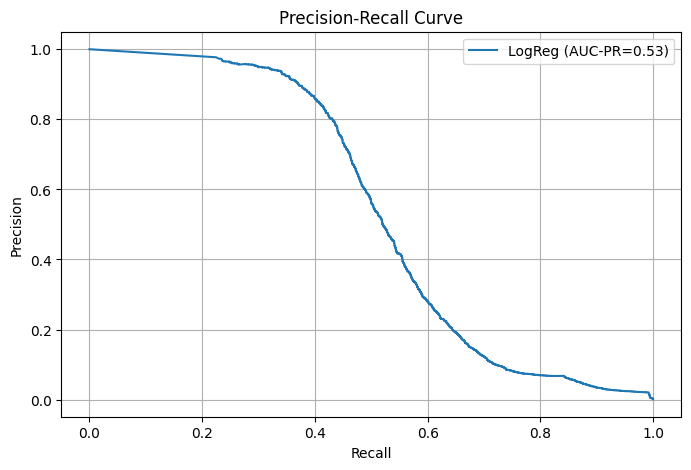

In [ ]:
from sklearn.metrics import classification_report, precision_recall_curve, roc_auc_score, average_precision_score

# Predict probabilities and classes on test set
y_probs = lr_model.predict_proba(X_test)[:, 1]
y_pred = lr_model.predict(X_test)

# Classification report
print("Classification report:")
print(classification_report(y_test, y_pred))

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Average Precision (AUC-PR): {pr_auc:.4f}")

# Plot Precision-Recall curve
plt.figure(figsize=(8,5))
plt.plot(recall, precision, label=f'LogReg (AUC-PR={pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np

y_probs = best_model.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)

best_thresh = thresholds[np.argmax(f1_scores)]
print("Best Threshold:", best_thresh)

# Use threshold for final prediction
y_pred_final = (y_probs >= best_thresh).astype(int)
print("F1 Score:", f1_score(y_test, y_pred_final))


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_train)


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'scale_pos_weight': [10, 20, 30]
}

xgb = XGBClassifier(eval_metric='aucpr', use_label_encoder=False)
grid = GridSearchCV(xgb, param_grid, scoring='average_precision', cv=3, verbose=1)
grid.fit(X_resampled, y_resampled)

print("Best params:", grid.best_params_)
best_model = grid.best_estimator_



Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:33:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:34:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:35:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:35:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:36:16] WARNING: /w

Best params: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'scale_pos_weight': 30}


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, average_precision_score

# Use the best model to predict test set labels
best_model = grid.best_estimator_

# Predict class labels
y_pred = best_model.predict(X_test)

# Predict class probabilities for metrics like ROC AUC, Average Precision
y_probs = best_model.predict_proba(X_test)[:, 1]

# Print classification report (precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC AUC: {roc_auc:.4f}")

# Calculate Average Precision score (AUC-PR)
avg_precision = average_precision_score(y_test, y_probs)
print(f"Average Precision (AUC-PR): {avg_precision:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.19      0.32   1906322
           1       0.00      1.00      0.00      2464

    accuracy                           0.19   1908786
   macro avg       0.50      0.59      0.16   1908786
weighted avg       1.00      0.19      0.32   1908786

Accuracy: 0.1925
ROC AUC: 0.7733
Average Precision (AUC-PR): 0.0029
